In [1]:
import cv2
import keras
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# list of networks to be studies
path1 = '/home/arash/Desktop/giessen/models/resnet50_org.h5'
path2 = '/home/arash/Desktop/giessen/models/resnet50_cv.h5'
path3 = '/home/arash/Desktop/all/restnet50_illum0_model.h5'
network1 = keras.models.load_model(path1)
network2 = keras.models.load_model(path2)
network3 = keras.models.load_model(path3)

/home/arash/tensorflow3/lib/python3.5/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# getting the weights, names, their difference for convolutional layers and depthwise conv
# keras.layers.core.Dense
def get_weights(network,
                which_layers=[keras.layers.convolutional.Conv2D or type(layers1) is keras.layers.DepthwiseConv2D]):
    all_weights = []
    layer_names = []
    for i, layers in enumerate(network.layers):
        if type(layers) in which_layers:
            layer_names.append(layers.name)

            layer = layers.get_weights()
            weights = layer[0]

            all_weights.append(weights)
    return (all_weights, layer_names)

def get_activations(network, layer):
    layer_model = keras.Model(inputs=network.input, outputs=layer.output)
    return layer_model

In [4]:
(all_weights1, layer_names) = get_weights(network1)
(all_weights2, layer_names) = get_weights(network2)
(all_weights3, layer_names) = get_weights(network3)

In [5]:
def compute_metric(all_weights1, all_weights2, metric='pearsonr'):
    all_metric = []
    for weights1, weights2 in zip(all_weights1, all_weights2):
        kernel_metric = np.zeros((weights1.shape[3], 1))
        for i in range(weights1.shape[3]):
            kernel1 = weights1[:,:,:,i]
            kernel2 = weights2[:,:,:,i]
            if metric == 'pearsonr':
                (r, p) = pearsonr(kernel1.flatten(), kernel2.flatten())
            #r = mutual_info_score(kernel1.flatten(), kernel2.flatten())
            #r = normalized_mutual_info_score(kernel1.flatten(), kernel2.flatten())
            #r = np.mean(np.abs(kernel1.flatten() - kernel2.flatten()))
            kernel_metric[i, 0] = r
        all_metric.append(kernel_metric)
    return all_metric

def print_metric(all_metric, layer_names):
    metric_summery = np.zeros((len(layer_names), 4))
    for i in range(len(layer_names)):
        metric_summery[i,0] = all_metric[i].max()
        metric_summery[i,1] = all_metric[i].min()
        metric_summery[i,2] = all_metric[i].mean()
        metric_summery[i,3] = all_metric[i].std()
        print('%s\t%0.4f\t%0.4f\t%0.4f\t%0.4f' % 
              (layer_names[i], metric_summery[i,0], metric_summery[i,1], metric_summery[i,2], metric_summery[i,3]))
    return metric_summery

def get_kernels_metric_threshold(all_metric, layer_names, threshold):
    metric_summery = []
    for i in range(len(layer_names)):
        conditioned_list = all_metric[i] <= threshold
        passed_inds = [j for j, x in enumerate(conditioned_list) if x]
        metric_summery.append(passed_inds)
    return metric_summery

def plot_metric_summary(metric_summery):
    plt.figure(1, figsize=(20, 2))
    plt.subplot(131)
    plt.plot(metric_summery[:,0])
    plt.title('Max')

    plt.subplot(132)
    plt.plot(metric_summery[:,1])
    plt.title('Min')

    plt.subplot(133)
    plt.errorbar(np.arange(0, len(layer_names), 1), metric_summery[:,2], yerr=metric_summery[:,3], fmt='o')
    plt.title('Mean +- 1 STD')
    plt.yscale('log')

    plt.show()
    
def plot_activities(a1, a2, a3, k):
    #plt.figure(1, figsize=(2, 2))
    ax0 = plt.subplot(131)
    ax0.matshow(a1[:,:,:,k].squeeze(), cmap='gray')
    ax0.axis('off')

    ax1 = plt.subplot(132)
    ax1.matshow(a2[:,:,:,k].squeeze(), cmap='gray')
    ax1.axis('off')

    ax2 = plt.subplot(133)
    ax2.matshow(a3[:,:,:,k].squeeze(), cmap='gray')
    ax2.axis('off')

In [6]:
corr_metric_org_cv = compute_metric(all_weights1, all_weights2, metric='pearsonr')
metric_summery_org_cv = print_metric(corr_metric_org_cv, layer_names)

conv1_01	1.0000	0.7941	0.9947	0.0261
res2a_branch2a	0.9999	0.9771	0.9985	0.0031
res2a_branch2b	0.9993	0.9480	0.9914	0.0117
res2a_branch2c	1.0000	0.4401	0.9897	0.0390
res2a_branch1	1.0000	0.7532	0.9950	0.0197
res2b_branch2a	0.9990	0.9780	0.9954	0.0042
res2b_branch2b	0.9992	0.9805	0.9967	0.0035
res2b_branch2c	0.9997	0.7552	0.9896	0.0266
res2c_branch2a	1.0000	0.9972	0.9984	0.0005
res2c_branch2b	0.9994	0.9975	0.9990	0.0003
res2c_branch2c	0.9999	0.7642	0.9894	0.0275
res3a_branch2a	0.9992	0.9858	0.9975	0.0018
res3a_branch2b	0.9994	0.9728	0.9961	0.0037
res3a_branch2c	0.9997	0.4216	0.9894	0.0450
res3a_branch1	0.9996	0.7694	0.9952	0.0143
res3b_branch2a	1.0000	0.9852	0.9972	0.0017
res3b_branch2b	0.9989	0.9917	0.9977	0.0009
res3b_branch2c	0.9997	0.7596	0.9911	0.0239
res3c_branch2a	0.9991	0.9801	0.9942	0.0035
res3c_branch2b	0.9994	0.9656	0.9951	0.0047
res3c_branch2c	0.9996	0.1852	0.9549	0.1354
res3d_branch2a	0.9996	0.9969	0.9988	0.0005
res3d_branch2b	0.9995	0.9972	0.9986	0.0005
res3d_branch2c	0.99

In [7]:
corr_metric_org_il = compute_metric(all_weights1, all_weights3, metric='pearsonr')
metric_summery_org_il = print_metric(corr_metric_org_il, layer_names)

conv1_01	1.0000	0.9576	0.9964	0.0089
res2a_branch2a	0.9999	0.9871	0.9986	0.0024
res2a_branch2b	0.9996	0.9727	0.9952	0.0049
res2a_branch2c	1.0000	0.1567	0.9889	0.0718
res2a_branch1	1.0000	0.4627	0.9937	0.0366
res2b_branch2a	0.9996	0.9868	0.9977	0.0020
res2b_branch2b	0.9995	0.9904	0.9982	0.0015
res2b_branch2c	0.9998	0.8315	0.9910	0.0238
res2c_branch2a	1.0000	0.9979	0.9990	0.0003
res2c_branch2b	0.9996	0.9976	0.9994	0.0003
res2c_branch2c	0.9999	0.8276	0.9912	0.0212
res3a_branch2a	0.9993	0.9882	0.9980	0.0015
res3a_branch2b	0.9994	0.9844	0.9970	0.0027
res3a_branch2c	0.9997	0.6614	0.9916	0.0322
res3a_branch1	0.9996	0.8135	0.9959	0.0106
res3b_branch2a	1.0000	0.9870	0.9979	0.0014
res3b_branch2b	0.9991	0.9895	0.9982	0.0009
res3b_branch2c	0.9998	0.7301	0.9908	0.0253
res3c_branch2a	0.9978	0.9621	0.9895	0.0083
res3c_branch2b	0.9989	0.9186	0.9925	0.0094
res3c_branch2c	0.9993	0.0893	0.9557	0.1318
res3d_branch2a	0.9997	0.9956	0.9988	0.0007
res3d_branch2b	0.9995	0.9979	0.9989	0.0003
res3d_branch2c	0.99

In [8]:
corr_metric_il_cv = compute_metric(all_weights3, all_weights2, metric='pearsonr')
metric_summery_il_cv = print_metric(corr_metric_il_cv, layer_names)

conv1_01	1.0000	0.8294	0.9935	0.0252
res2a_branch2a	0.9999	0.9711	0.9973	0.0056
res2a_branch2b	0.9995	0.9433	0.9911	0.0125
res2a_branch2c	1.0000	-0.1326	0.9850	0.0859
res2a_branch1	1.0000	0.6191	0.9909	0.0363
res2b_branch2a	0.9993	0.9777	0.9961	0.0045
res2b_branch2b	0.9997	0.9842	0.9976	0.0031
res2b_branch2c	0.9998	0.5456	0.9886	0.0395
res2c_branch2a	1.0000	0.9978	0.9990	0.0004
res2c_branch2b	0.9997	0.9974	0.9994	0.0003
res2c_branch2c	0.9999	0.8342	0.9924	0.0193
res3a_branch2a	0.9996	0.9857	0.9983	0.0018
res3a_branch2b	0.9995	0.9880	0.9985	0.0015
res3a_branch2c	0.9999	0.2679	0.9880	0.0565
res3a_branch1	0.9997	0.8399	0.9955	0.0107
res3b_branch2a	1.0000	0.9935	0.9982	0.0009
res3b_branch2b	0.9995	0.9925	0.9987	0.0007
res3b_branch2c	0.9999	0.5517	0.9899	0.0330
res3c_branch2a	0.9980	0.9528	0.9858	0.0106
res3c_branch2b	0.9984	0.8738	0.9894	0.0141
res3c_branch2c	0.9988	-0.1755	0.9513	0.1416
res3d_branch2a	0.9998	0.9951	0.9989	0.0010
res3d_branch2b	0.9996	0.9987	0.9993	0.0002
res3d_branch2c	0.

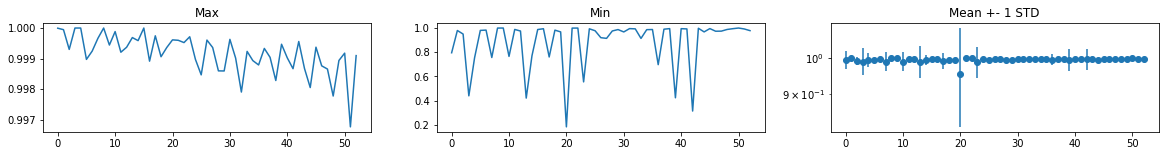

In [137]:
plot_metric_summary(metric_summery_org_cv)

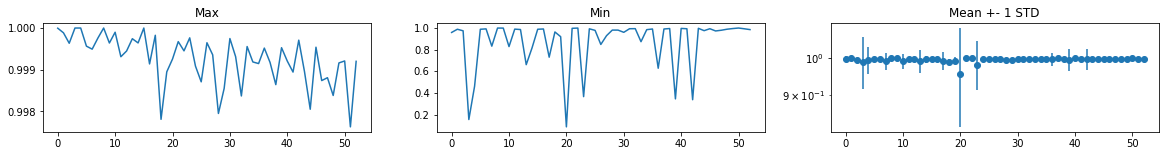

In [138]:
plot_metric_summary(metric_summery_org_il)

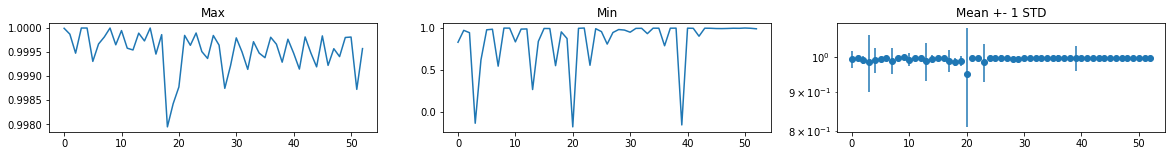

In [139]:
plot_metric_summary(metric_summery_il_cv)

In [9]:
threshold_org_il = get_kernels_metric_threshold(corr_metric_org_il, layer_names, 0.5)
threshold_org_cv = get_kernels_metric_threshold(corr_metric_org_cv, layer_names, 0.5)
threshold_il_cv = get_kernels_metric_threshold(corr_metric_il_cv, layer_names, 0.5)

In [14]:
kernels = sorted(list(set(threshold_org_il[20]).intersection(threshold_org_cv[20]).intersection(threshold_il_cv[20])))
print(kernels)

[27, 129, 138, 155, 195, 260, 301, 368, 406, 462, 482, 511]


In [15]:
image_path = '/home/arash/Software/repositories/kernelphysiology/data/computervision/ilsvrc/ilsvrc2012/raw-data/validation/n03201208/ILSVRC2012_val_00000503.JPEG'
image = keras.preprocessing.image.load_img(image_path, target_size=(224,224))
x = keras.preprocessing.image.img_to_array(image)
x_pre = keras.applications.resnet50.preprocess_input(x.copy())
x_pre = np.expand_dims(x_pre, axis=0)

In [16]:
activities1 = get_activations(network1, network1.get_layer('res3c_branch2c')).predict(x_pre)
activities2 = get_activations(network2, network2.get_layer('res3c_branch2c')).predict(x_pre)
activities3 = get_activations(network3, network3.get_layer('res3c_branch2c')).predict(x_pre)

In [17]:
def plot_activities(activities, k):
    n = 1
    m = 12
    for i, kernel in enumerate(k):
        ax = plt.subplot(n, m, i+1)
        ax.matshow(activities[:,:,:,kernel].squeeze(), cmap='gray')
        ax.axis('off')

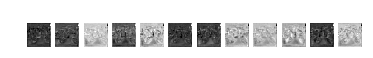

In [35]:
plot_activities(activities1, kernels)

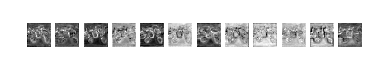

In [36]:
plot_activities(activities2, kernels)

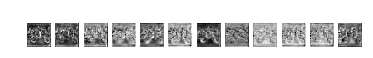

In [37]:
plot_activities(activities3, kernels)

3 [204]
20 [27, 129, 138, 155, 195, 260, 301, 368, 406, 462, 482, 511]


/home/arash/tensorflow3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


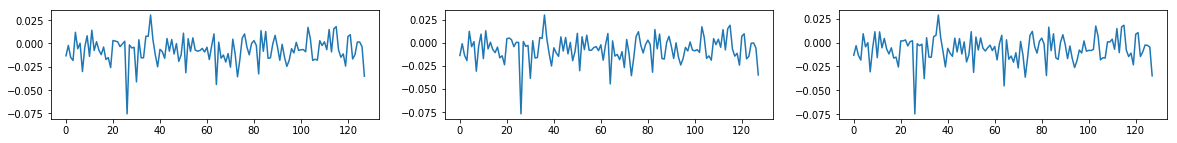

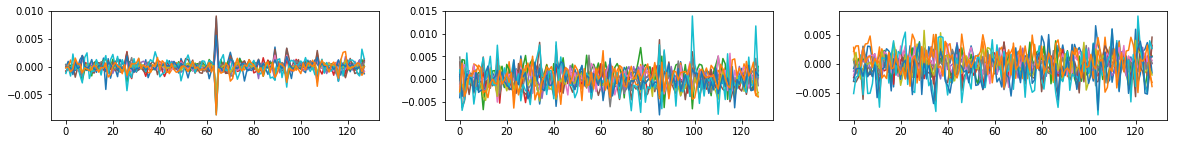

In [24]:
for i in range(len(layer_names)):
    kernels = sorted(list(set(threshold_org_il[i]).intersection(threshold_org_cv[i]).intersection(threshold_il_cv[i])))
    if kernels:
        print(i, kernels)
        plt.figure(figsize=(20, 2))
        for kernel_ind in kernels:
            w1 = all_weights1[20][:,:,:,kernel_ind]
            w2 = all_weights2[20][:,:,:,kernel_ind]
            w3 = all_weights3[20][:,:,:,kernel_ind]
            plt.subplot(1,3,1).plot(w1.flatten())
            plt.subplot(1,3,2).plot(w2.flatten())
            plt.subplot(1,3,3).plot(w3.flatten())

In [45]:
w1 = all_weights1[20][:,:,:,kernels[0]]
print(w1.mean(), w1.std(), w1.max(), w1.min())

3.697002e-05 0.0013254237 0.008758795 -0.0041185715


In [46]:
w2 = all_weights2[20][:,:,:,kernels[0]]
print(w2.mean(), w2.std(), w2.max(), w2.min())

0.00019252274 0.0020505958 0.0050725886 -0.007910019


In [47]:
w3 = all_weights3[20][:,:,:,kernels[0]]
print(w3.mean(), w3.std(), w3.max(), w3.min())

0.0006942045 0.0018957871 0.0065348665 -0.0040123854


/home/arash/tensorflow3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


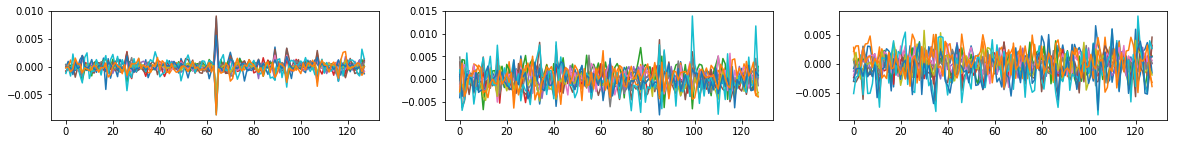

In [61]:
for kernel_ind in kernels:
    w1 = all_weights1[20][:,:,:,kernel_ind]
    w2 = all_weights2[20][:,:,:,kernel_ind]
    w3 = all_weights3[20][:,:,:,kernel_ind]
    plt.figure(1, figsize=(20, 2))
    plt.subplot(1,3,1).plot(w1.flatten())
    plt.subplot(1,3,2).plot(w2.flatten())
    plt.subplot(1,3,3).plot(w3.flatten())